<a href="https://colab.research.google.com/github/sugarchins/ML-NLP-Projects/blob/main/NLP_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas.plotting import scatter_matrix
from matplotlib.gridspec import GridSpec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import keras

In [ ]:

from sklearn import tree # Import the tree module for DecisionTreeClassifier in GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding,create_optimizer
from tensorflow.keras.optimizers import Adam
#from kerastuner.tuners import RandomSearch


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [ ]:


df_train = pd.read_csv('train.txt', sep=';', names=['text', 'emotion'])
df_val = pd.read_csv('val.txt', sep=';', names=['text', 'emotion'])
df_test = pd.read_csv('test.txt', sep=';', names=['text', 'emotion'])

# Combine datasets
df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)
df.head()


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


Tokenization and padding

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,emotion,label,clean_text
0,i didnt feel humiliated,sadness,4,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,4,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,0,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,3,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,0,feeling grouchy


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode emotions as integers
le = LabelEncoder()
df['label'] = le.fit_transform(df['emotion'])  # e.g., anger→0, fear→1, etc.

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad to length 50 (max_len)
max_len = 50
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = pd.get_dummies(df['label']).values  # one-hot encode labels

# Train/Validation/Test split (stratified by label)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Shapes → X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


Shapes → X_train: (16000, 50) X_val: (2000, 50) X_test: (2000, 50)


# Model

In [ ]:


vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 128
max_len=50
def build_simple_rnn():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        SimpleRNN(64),
        Dense(32, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_lstm():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_gru():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        GRU(64),
        Dense(32, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_bi_lstm():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(64)),
        Dense(32, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_stacked_lstm():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(32, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

rnn_models = {
    'SimpleRNN': build_simple_rnn(),
    'LSTM':     build_lstm(),
    'GRU':      build_gru(),
    'BiLSTM':   build_bi_lstm(),
    'StackedLSTM': build_stacked_lstm()
}

histories = {}  # to store training history

for name, model in rnn_models.items():
    print(f"\nTraining model: {name}")
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[es],
        verbose=1
    )
    histories[name] = history



Training model: SimpleRNN
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3210 - loss: 1.5975 - val_accuracy: 0.3380 - val_loss: 1.5776
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.3419 - loss: 1.5769 - val_accuracy: 0.3145 - val_loss: 1.5895
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3474 - loss: 1.5715 - val_accuracy: 0.3345 - val_loss: 1.5802

Training model: LSTM
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3265 - loss: 1.5992 - val_accuracy: 0.3380 - val_loss: 1.5782
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3342 - loss: 1.5769 - val_accuracy: 0.3380 - val_loss: 1.5765
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3317 - loss: 1.5842 - val_accuracy: 0.3380 - val_loss: 1.5771
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3454 - loss: 1.5718 - val_accuracy: 0.3380 - val_loss: 1.5754
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - 

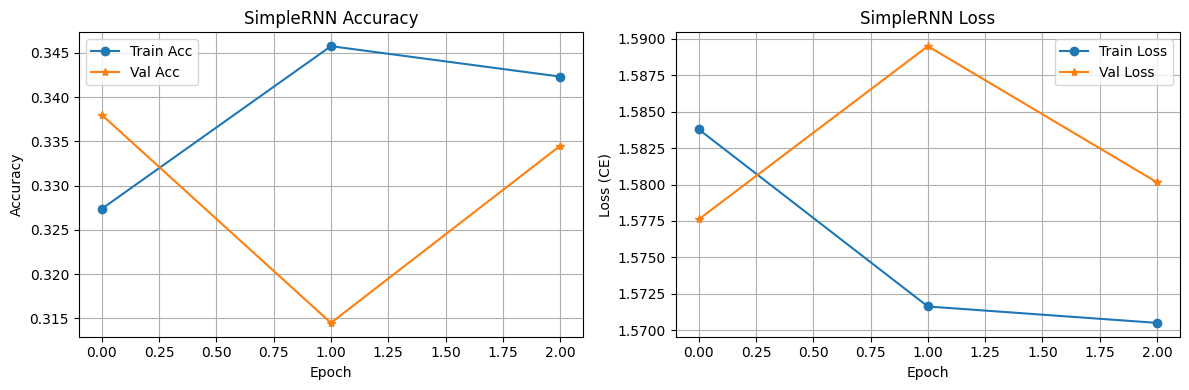

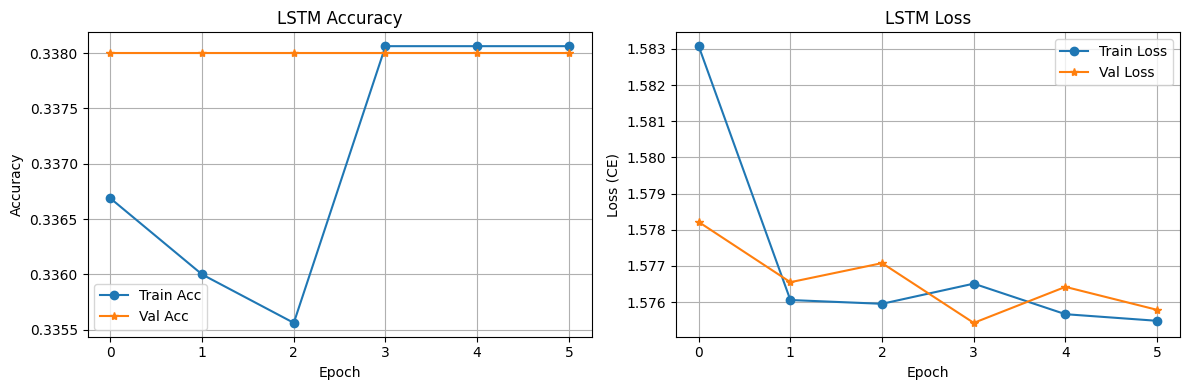

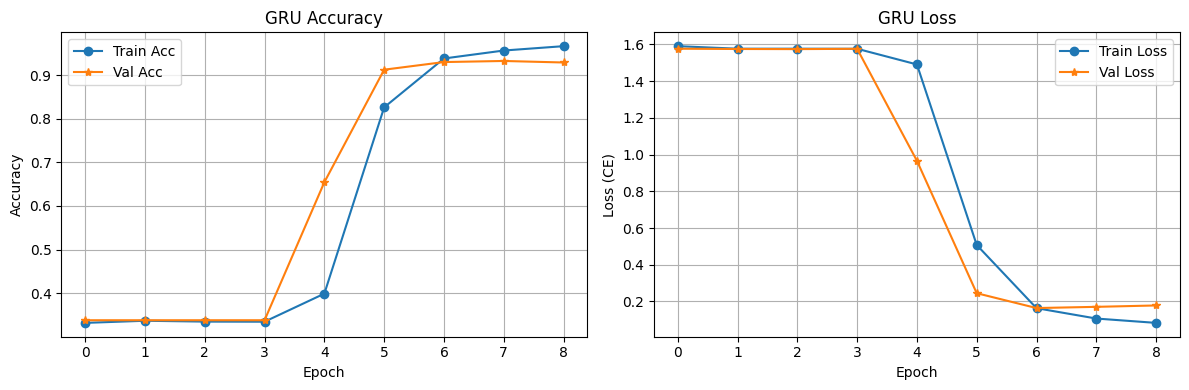

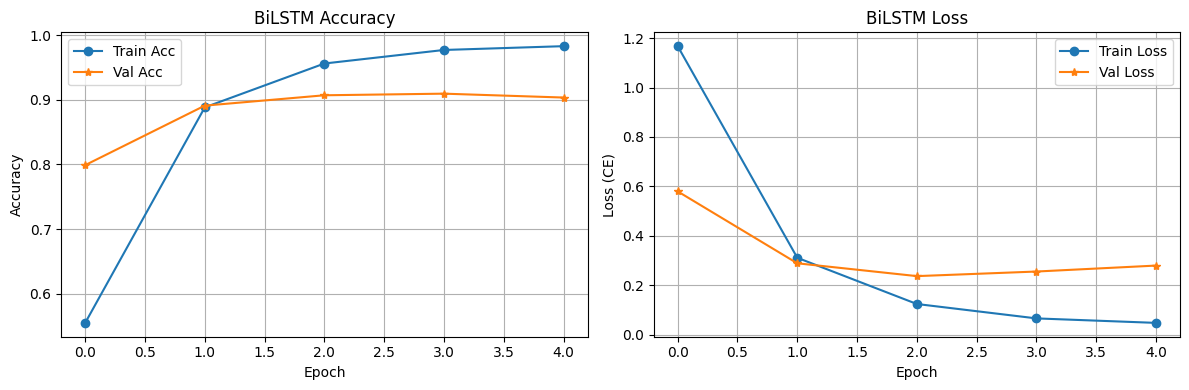

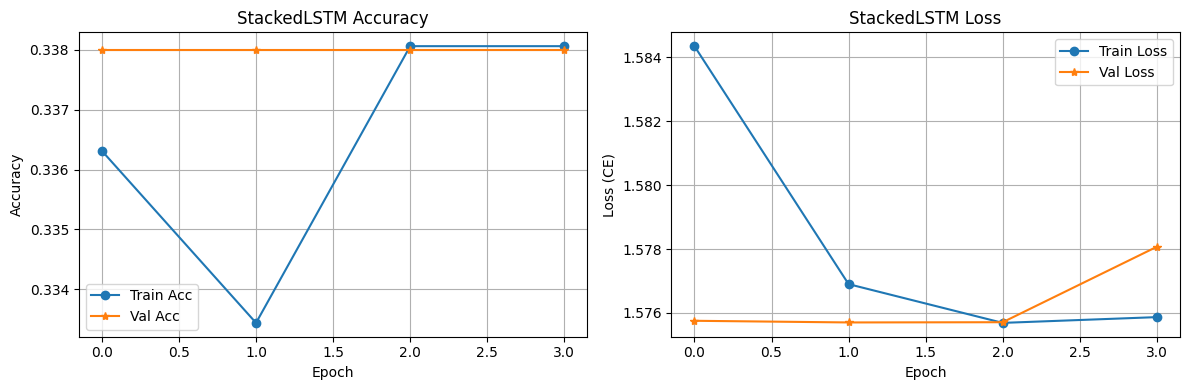

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    # Accuracy plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(history.history['val_accuracy'], marker='*', label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], marker='o', label='Train Loss')
    plt.plot(history.history['val_loss'], marker='*', label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (CE)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot for each RNN-based model
for name, history in histories.items():
    plot_history(history, name)


# Hyperparameter Tuning

In [ ]:

!pip install keras-tuner
import keras_tuner as kt

def build_tuned_lstm(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embed_dim', [64, 128, 256]),
        input_length=max_len
    ))
    model.add(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dense(y_train.shape[1], activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_tuned_lstm,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='emotion_tuner',
    project_name='lstm_tuning'
)

# Run the search
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

best_lstm_model = tuner.hypermodel.build(best_hps)
history_best_lstm = best_lstm_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
)


Trial 5 Complete [00h 01m 01s]
val_accuracy: 0.33799999952316284

Best val_accuracy So Far: 0.6705000102519989
Total elapsed time: 00h 06m 42s
Best Hyperparameters: {'embed_dim': 64, 'lstm_units': 128, 'dropout': 0.1, 'dense_units': 96, 'learning_rate': 0.0001}
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3224 - loss: 1.6277 - val_accuracy: 0.3380 - val_loss: 1.5753
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3353 - loss: 1.5767 - val_accuracy: 0.3380 - val_loss: 1.5758
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3385 - loss: 1.5707 - val_accuracy: 0.3380 - val_loss: 1.5748
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3373 - loss: 1.5642 - val_accuracy: 0.3755 - val_loss: 1.2569
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4164 - loss: 1.1518 - val_accuracy: 0.4695 - val_loss: 1.1156
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4701 - loss: 1.0321 - val_accura

#Using Pretrained Model

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


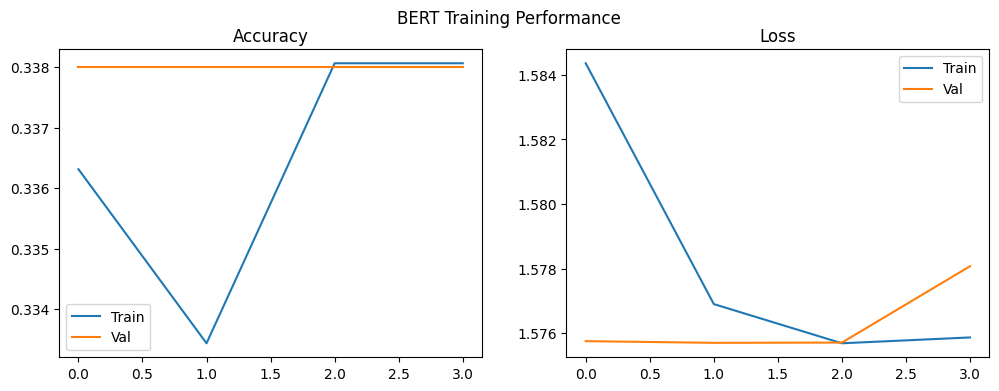

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

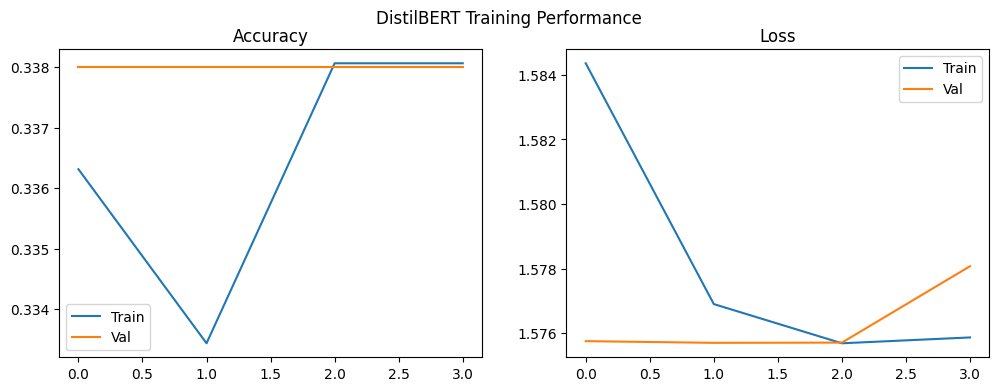

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

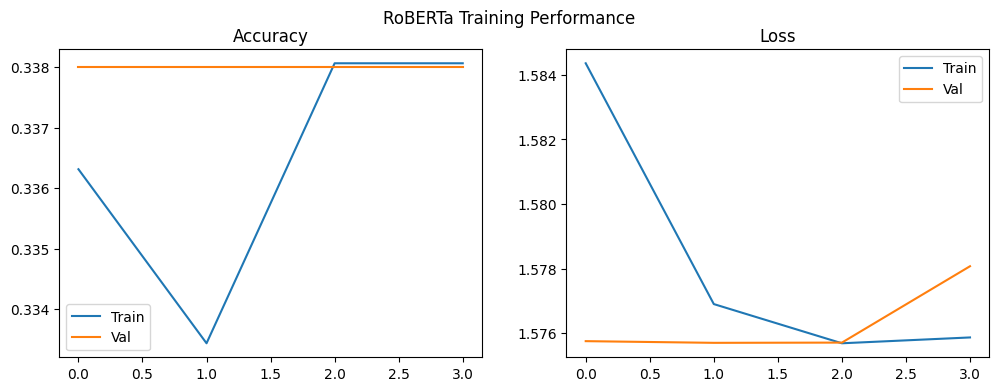

In [ ]:
from transformers import (
    AutoTokenizer, TFAutoModelForSequenceClassification,
    DataCollatorWithPadding, create_optimizer
)
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt

df_train['label'] = le.transform(df_train['emotion'])  # already encoded above

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_train['text'], df_train['label'], test_size=0.2, stratify=df_train['label'], random_state=42
)

train_ds = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_ds = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

models = {
    "BERT": "bert-base-uncased",
    "DistilBERT": "distilbert-base-uncased",
    "RoBERTa": "roberta-base"
}

results = {}

for model_name, model_checkpoint in models.items():
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    def tokenize_function(example): return tokenizer(example["text"], truncation=True)
    tokenized_train = train_ds.map(tokenize_function, batched=True)
    tokenized_test = test_ds.map(tokenize_function, batched=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=len(le.classes_))

    optimizer, _ = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=len(tokenized_train))
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


    # Save final accuracy
    results[model_name] = history.history['val_accuracy'][-1]

    # Plot learning curves
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'{model_name} Training Performance')
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title('Accuracy'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss'); plt.legend()
    plt.show()

In [ ]:
print("Final Train Accuracy: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("Final Val Accuracy: {:.2f}%".format(history.history['val_accuracy'][-1] * 100))

Final Train Accuracy: 33.81%
Final Val Accuracy: 33.80%


In [ ]:


# Comparison
model_accuracies = {}

# Get accuracies for SimpleRNN, LSTM, GRU, BiLSTM, StackedLSTM from 'histories'
for name, history in histories.items():
    if history.history and 'val_accuracy' in history.history:
        model_accuracies[name] = history.history['val_accuracy'][-1]
    else:
        model_accuracies[name] = None # Or some indicator of failure/no validation data


# Get accuracy for the best tuned LSTM model
if history_best_lstm.history and 'val_accuracy' in history_best_lstm.history:
     model_accuracies['Tuned LSTM'] = history_best_lstm.history['val_accuracy'][-1]
else:
    model_accuracies['Tuned LSTM'] = None # Or some indicator of failure/no validation data

for name, acc in results.items():
    model_accuracies[name] = acc


# Create a DataFrame for comparison
comparison_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Validation Accuracy'])

# Sort by accuracy
comparison_df = comparison_df.sort_values(by='Validation Accuracy', ascending=False).reset_index(drop=True)

# Display the table
print("\nModel Comparison Table:")
print(comparison_df.to_markdown(index=False)) # Using to_markdown for better display in Colab/Jupyter



Model Comparison Table:
| Model       |   Validation Accuracy |
|:------------|----------------------:|
| GRU         |                0.929  |
| BiLSTM      |                0.9035 |
| Tuned LSTM  |                0.627  |
| StackedLSTM |                0.338  |
| LSTM        |                0.338  |
| DistilBERT  |                0.338  |
| BERT        |                0.338  |
| RoBERTa     |                0.338  |
| SimpleRNN   |                0.3345 |
